In [1]:
import numpy as np
import cv2
import json
import matplotlib.path as mpltPath
import os
import warnings
import tifffile
from skimage import exposure
from skimage.exposure import match_histograms
import xml.etree.ElementTree as ET
import pandas as pd
from PIL import Image
from math import sqrt
import matplotlib.pyplot as plt
from glob import glob
from copy import copy
from tqdm.notebook import tqdm
import warnings
import torchstain
import torch
from torchvision import transforms

# 경고 메시지를 무시하도록 설정s
warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

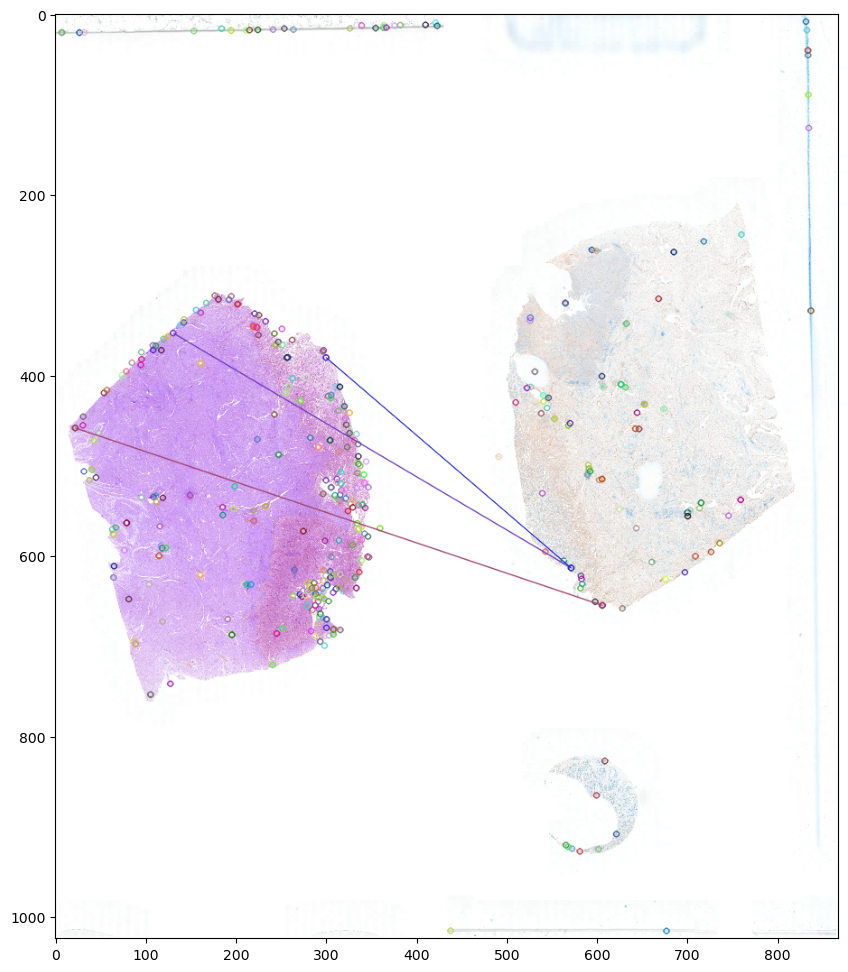

In [65]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*255)
])

torch_normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')


img1 = cv2.imread('../../data/virtual_stain/image_surf/thumb/HE/S21-30016-11.tiff')
img2 = cv2.imread('../../data/virtual_stain/image_surf/thumb/MSH6/S21-30016-11.tiff')
img1=cv2.resize(img1,(img1.shape[1]//2,img1.shape[0]//2))
img2=cv2.resize(img2,(img2.shape[1]//2,img2.shape[0]//2))
gray1 =cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 =cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

# 키포인트와 디스크립터를 찾습니다.
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2 , None)

# BFMatcher(Brute-Force Matcher) 객체를 생성합니다.
bf = cv2.BFMatcher()
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # 검색 파라미터 설정
flann = cv2.FlannBasedMatcher(index_params, search_params)

# 특징점 매칭을 수행합니다.
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# 좋은 매칭 포인트를 선택합니다.
good_matches = []
for m, n in matches:
    if m.distance < 0.7* n.distance:
        good_matches.append(m)

# 매칭 결과를 그리기 위한 이미지를 생성합니다.
result_img = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None)

# 결과 이미지를 표시합니다.
plt.figure(figsize=(12,12))
plt.imshow(result_img)

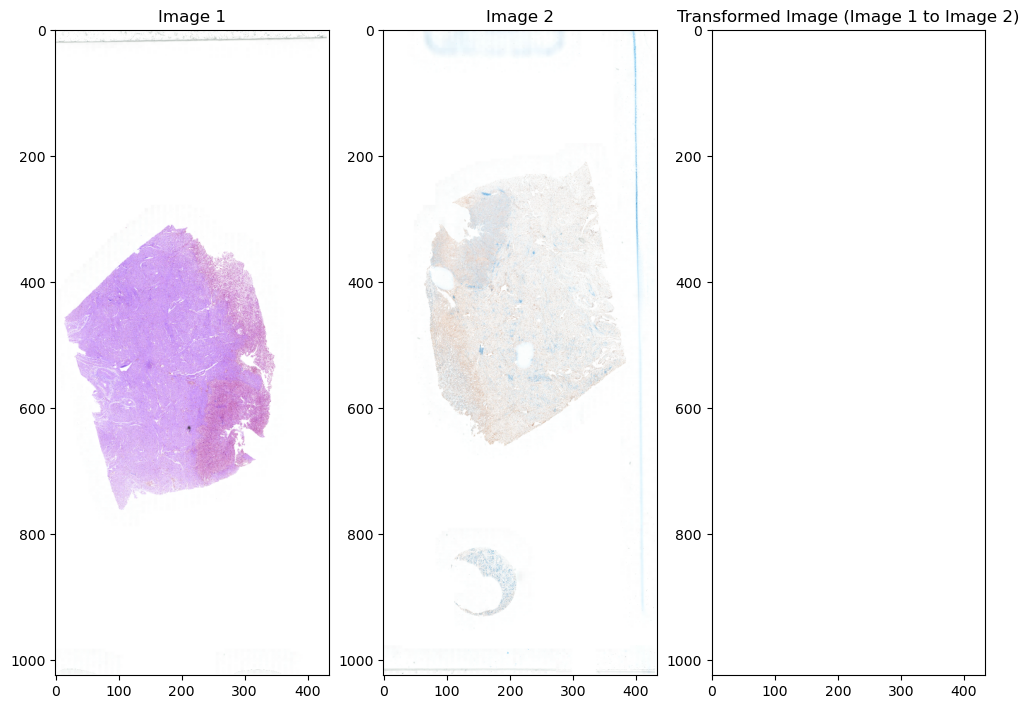

In [64]:
good_kp1 = [keypoints1[m.queryIdx] for m in good_matches]
good_kp2 = [keypoints2[m.trainIdx] for m in good_matches]

# 매칭 포인트의 좌표를 NumPy 배열로 변환
pts1 = np.float32([kp.pt for kp in good_kp1])
pts2 = np.float32([kp.pt for kp in good_kp2])

# Affine 변환 행렬 추정
affine_transform = cv2.estimateAffinePartial2D(pts1, pts2)[0]

# 이미지1을 이미지2에 맞게 변환
result = cv2.warpAffine(img1, affine_transform, (img2.shape[1], img2.shape[0]))

# 변환된 이미지를 출력
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1), plt.imshow(img1), plt.title('Image 1')
plt.subplot(1, 3, 2), plt.imshow(img2), plt.title('Image 2')
plt.subplot(1, 3, 3), plt.imshow(result), plt.title('Transformed Image (Image 1 to Image 2)')
plt.show()

In [158]:
affine_transform

array([[ 8.89668387e-01, -3.05297147e-03,  1.37701203e+01],
       [ 3.05297147e-03,  8.89668387e-01,  1.00967729e+02]])